In [1]:
## IPython extension to reload modules before executing user code.
# Autorelad is an IPython extension to reload modules before executing user code.
%load_ext autoreload

# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

In [2]:
from matplotlib import pyplot as plt

import os
from os.path import join
import sys
from IPython.display import display
from PIL import Image

ROOT_DIR = os.sep.join(os.path.abspath('.').split(os.sep)[:-1])
sys.path.insert(0, ROOT_DIR)
DATASET_DIR = "{}/data".format(ROOT_DIR)
print(DATASET_DIR)

/home/djoy2409-wsl/projects/caismd_qsar_2024/data


In [3]:
from typing import List, Union, Any, Tuple
from datetime import datetime
from random import sample

import pandas as pd
import numpy as np
from tqdm import tqdm
import re
# import torch

import pickle

from rdkit import Chem, RDLogger
from rdkit.Chem import Draw, AllChem, PandasTools, MolFromSequence, MolToSmiles, MolToInchiKey, Descriptors, GraphDescriptors
from rdkit.Chem import rdMolDescriptors as rdmdesc

from joblib import Parallel, delayed

RDLogger.DisableLog('rdApp.*')
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from lib import utilities, splitters, featurizers, visualization, preprocessing

from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.impute import SimpleImputer

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [4]:
seed = 3
utilities.set_seeds(seed=seed)

<p style="font-size=20px">
In the following, we will train classification models to predict the ability of small molecules to inhibit <em>P. falciparum's</em> DD2 growth.
</p>

<div>
<h2>Data Preparation</h2>
<p>
The dataset was obtained from the PubChem Biossay AID 2302. It was used as example in the paper by <a href="https://www.frontiersin.org/articles/10.3389/frai.2019.00017/full">Chakravarti and Mani Alla (2019); Frontiers in Artificial Intelligence, 2, DOI: 10.3389/frai.2019.00017</a>.
</p>

In [5]:
dd2_data_df   = pd.read_csv(f"{DATASET_DIR}/dd2_inhibition_pubchem_aid_2302.csv").iloc[:]
smiles_column = "PUBCHEM_EXT_DATASOURCE_SMILES"
target_column = "DD2_ACTIVITY_CLS"
mol_column    = 'RMol'
dd2_data_df.head()

,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PCT_INHIB_DD2
0,85857918,11957475.0,C1CN(CCN1CC(C(C2=CC=CC=C2)C3=CC=CC=C3)O)C4=CC(...,Inactive,4.0
1,85857919,6618861.0,C1CN(CC=C1C2=CNC3=CC=CC=C32)CC4=CC=CC=C4,Active,80.0
2,85857920,21924871.0,C1=CC(=CC=C1C2=CC3=C(N2)C=C(C=C3)C(=N)N)C(=N)N.Cl,Active,99.0
3,85857921,1365597.0,C1=CC(=CC=C1C2=NC3=C(N2)C=C(C=C3)C4=CC5=C(C=C4...,Active,96.0
4,85857922,10115148.0,C1=CC(=CC=C1C2=NC3=C(N2)C=C(C=C3)C4=CC5=C(C=C4...,Active,99.0


<div>
<h3>Dataset Cleaning</h3>

</div>

<span>
Below are some steps that we must implement:
<ol>
    <li> Remove samples with empty SMILES strings.</li>
    <li>Select the largest fragment for each molecule, which will also remove slats, among others. We will use the SMILES and inchikeys of the fragment.</li>
    <li>Sanitize the retained molecule</li>
    <li> Check for data integrity w.r.t labels. Are there duplicate molecules with different labels?
    <li>Remove deplicate molecules (via InChIKeys)</li>
<!--
    <li>Remove duplicates, using the inchikey as primary key. For each group of duplicates: </li> 
        <ol>
            <li>If the min and max values are apart by 20 or more, omit and proceed to the next group</li>
            <li>Else, retain the first occurrence but replace the target value by an average</li>
            <li>It is worth mentioning that duplicate removal is usually a more involved process, where outliers can be detected and removed using a statisical approach, before averaging the taarget value.</li>
        </ol>
        -->
</ol>
</span>

In [6]:
dd2_data_df    = preprocessing.clean_data(dd2_data_df, target_column, smiles_column, mol_column)
molecules_list = dd2_data_df['largest_frag']

dd2_data_df.head(2)

Original shape: (13533, 5)
Number of molecules with a missing SMILES string: 13/13533

Number of row with undefined label:  0


Failed to patch pandas - unable to change molecule rendering


ddf: (13520, 10)



Number of molecules with a missing largest fragment SMILES string: 0/13520

Number of unique inchikeys: 13451/13520

Number of duplicates inchikeys: 136 - e.g.: Index([11030, 11031], dtype='int64')


Examples of duplicates                  largest_frag_ikey  DD2_ACTIVITY_CLS
11030  AORQSRDHRDBKEY-VZUCSPMQSA-N                 1
11031  AORQSRDHRDBKEY-VZUCSPMQSA-N                 1
11112  APVCKZHNYULVKZ-UHFFFAOYSA-N                 1
11128  APVCKZHNYULVKZ-UHFFFAOYSA-N                 1
10900  BMMRCXDMRSOLOI-SAPNQHFASA-N                 1
10885  BMMRCXDMRSOLOI-SAPNQHFASA-N                 1
8505   BOLZBUKPPORRCG-UHFFFAOYSA-N                 1
10005  BOLZBUKPPORRCG-UHFFFAOYSA-N                 1
11095  CMLBYLLNXLSKBL-UHFFFAOYSA-N                 1
11083  CMLBYLLNXLSKBL-UHFFFAOYSA-N                 1


Removing duplicates...

Removing replicates with conflicting values.
[9455, 9254]
Example of f molecule with conflicting replicate measurements...

                largest_

,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PCT_INHIB_DD2,DD2_ACTIVITY_CLS,RMol,largest_frag,largest_frag_smiles,largest_frag_ikey
0,85857918,11957475.0,C1CN(CCN1CC(C(C2=CC=CC=C2)C3=CC=CC=C3)O)C4=CC(...,Inactive,4.0,0,<rdkit.Chem.rdchem.Mol object at 0x7fb3f8164c10>,<rdkit.Chem.rdchem.Mol object at 0x7fb3f8d3a580>,[H]OC([H])(C([H])(c1c([H])c([H])c([H])c([H])c1...,QJHCTHPYUOXOGM-UHFFFAOYSA-N
1,85857919,6618861.0,C1CN(CC=C1C2=CNC3=CC=CC=C32)CC4=CC=CC=C4,Active,80.0,1,<rdkit.Chem.rdchem.Mol object at 0x7fb3f8164d60>,<rdkit.Chem.rdchem.Mol object at 0x7fb3f8d3a660>,[H]C1=C(c2c([H])n([H])c3c([H])c([H])c([H])c([H...,TYKXLUMYKFFSJE-UHFFFAOYSA-N


<h3>Molecular Representations</h3>
<h4>Molecular properties and functional groups</h4>
Molecular descriptors can be grouped in various categories: The descriptors include:
<ul>
<li><b>Constitutional Descriptors</b> are based on the molecular structure itself, without considering the spatial arrangement of atoms. Examples include the molecular weight, the number of atoms, etc.</li>
<li><b>Geometrical Descriptors</b> describe the geometrical properties of a molecule, such as shape, size, and symmetry. Examples include the bond lenghts, torsion angles, radius of gyration etc.</li>
<li><b>Topological Descriptors</b> are based on the connectivity of atoms in the molecule, often represented by graphs. Examples include the Wiener, Balaban, and Zagreb indices</li>
<li><b>Electronic Descriptors</b> describe the electronic properties of molecules, such as electron density and energy levels. Examples include electron affinity, ionization potential, etc.</li>
<li><b>Constitutional/Functional Group Counts </b> counts specific types of atoms or functional groups in the molecule. Examples include the number of amine, and carboxyl groups</li>
<li><b></b></li>

</ul>
<br>We will computer physico-chemical properties using the RDKIT, and Mordred libraries. 

In [7]:
%%time
# features_ = None
features_ = [
                'CalcExactMolWt'
                , 'CalcTPSA', 'CalcNumAromaticRings', 'CalcNumAliphaticRings', 'CalcNumLipinskiHBA', 'CalcNumLipinskiHBD', 'qed'
                , 'CalcNumRotatableBonds', 'CalcNumAmideBonds'
                , 'MolLogP', 'HallKierAlpha', 'MaxPartialCharge', 'MinPartialCharge'
                , 'ExtendedTopochemicalAtom'
                , 'Polarizability'
                , 'ZagrebIndex'
                , 'MoeType'
            ]
mol_featurizer = featurizers.MoleculeFeaturizer(features = None)


CPU times: user 10 µs, sys: 2 µs, total: 12 µs
Wall time: 13.8 µs


In [8]:
%%time
mol_features = mol_featurizer.compute_properties_for_mols(molecules=molecules_list.values, as_dataframe=True, count_unique_bits=False)
mol_features.index = molecules_list.index

# ### Standardize
# standardizer = StandardScaler()
# mol_features = pd.DataFrame(standardizer.fit_transform(mol_features), columns=mol_features.columns)


mol_features[target_column] = dd2_data_df[target_column]
mol_features.to_csv(f"{DATASET_DIR}/dd2-mordred-rdkit.csv", index=False)

RDKIT property calculation: 78.81 seconds.


100%|██████████| 13487/13487 [00:56<00:00, 239.81it/s]


MORDRED property calculation: 57.008 seconds.
CPU times: user 2min 9s, sys: 5.4 s, total: 2min 14s
Wall time: 2min 17s


<h5>Adding custom features</h5>
<p> We will add the following features:</p>
<ol>
<li><b>Number (num_halo_atoms), and Weight Ratio (halo_weight_ratio) of Halogen Atoms:</b> Halogen atoms can impact the ADME profile of a molecule. They can also affect its activity, as they can the molecules binding interaction with target proteins. Moreover, due to their potential tp form reactive intermediates, they can contribute to toxicity.</li>
<li><b>Number (num_sp3_carbons), and Fraction (frac_sp3_carbons) of SP3 Carbon Atoms:</b> Molecules with a higher proportion of sp3-carbons tend to be more hydrophobic (water-insoluble) compared to those with more sp- and sp2-hybridized carbons. This can hinder their absorption from the gastrointestinal tract. Moreover, the bulky and hydrophobic environment created around the molecules with higher sp3-carbon ratios, can potentially affect protein binding. </li>
<li><b>Matches_lipinski's Rule of Five (lipisnki_ro5):</b>  Lipinski's Rule of Five is a rule of thumb used in drug discovery to predict the oral bioavailability of a drug candidate.</li>
</ol>

In [9]:
%%time

mol_features['largest_frag'] = dd2_data_df['largest_frag']
# print(mol_features['largest_frag'].head(5))
# print(mol_features['largest_frag'].dtype)
# print(featurizers.num_halogen_atoms(mol_features['largest_frag'][0]))
mol_features = preprocessing.add_custom_features(mol_features, bool_to_int=True, mol_column='largest_frag')
mol_features.drop(['largest_frag'], axis=1, inplace=True)
mol_features.to_csv(f"{DATASET_DIR}/dd2-mordred-rdkit.csv", index=False)

CPU times: user 8.53 s, sys: 86.4 ms, total: 8.62 s
Wall time: 8.62 s


In [10]:
custom_descriptors = ['num_halo_atoms', 'halo_weight_ratio', 'num_s3_carbons', 'frac_spe_carbons', 'lipinski_ro5']
mol_features.head(2)[custom_descriptors]

,num_halo_atoms,halo_weight_ratio,num_s3_carbons,frac_spe_carbons,lipinski_ro5
0,1,0.087117,10,0.344828,1
1,0,0.000000,5,0.227273,1


In [11]:

%%time 
#### Let's clean featuress
# mol_features = pd.read_csv(f"{DATASET_DIR}/dd2-mordred-rdkit.csv")
# cols_to_scale = [col for col in mol_features.columns.difference([target_column]) if re.match('^fr_', col) is None and not mol_features[col].dtype==bool]

## For now, we will only remove nan values, without scaling
mol_features = preprocessing.clean_features(mol_features, columns_to_clean=None, columns_to_scale=None, standardizer=None, strategy_num='median', strategy_cat='most_frequent')

mol_features.iloc[:5,-10:]

CPU times: user 325 ms, sys: 100 ms, total: 426 ms
Wall time: 425 ms


,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,DD2_ACTIVITY_CLS,num_halo_atoms,halo_weight_ratio,num_s3_carbons,frac_spe_carbons,lipinski_ro5
0,28.686600,-0.460630,4.403167,0.0,0.0,1.0,0.087117,10.0,0.344828,1.0
1,19.275790,5.666756,3.196898,0.0,1.0,0.0,0.000000,5.0,0.227273,1.0
2,15.179836,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.0,0.000000,0.0
3,27.926217,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.0,0.000000,0.0
4,27.834036,0.000000,0.000000,0.0,1.0,2.0,0.155718,2.0,0.062500,0.0


In [12]:
## Let's reduce the memory usage/footprint of the dataframe
mol_features = utilities.reduce_mem_usage(mol_features)

Memory usage of dataframe is 22.84 MB
Memory usage after optimization is: 5.71 MB
Decreased by 75.0%


In [13]:
## Correlations to the target
## The correlation coefficient is a statistical measure that quantifies the strength and direction of the linear relationship between two variables.
## 1: Indicates a perfect positive linear relationship, meaning that as one variable increases, the other variable also increases proportionally.
## 0: Implies no linear relationship between the variables.
## -1: Represents a perfect negative linear relationship, indicating that as one variable increases, the other variable decreases proportionally.

mol_features = pd.read_csv(f"{DATASET_DIR}/dd2-mordred-rdkit.csv")
correlations_ = mol_features.corr()[target_column].abs().sort_values(ascending=False).dropna()
print("TOP-10 Highest absolute correlations to the target")
print(correlations_[1:10])
print("\n'CalcNumRotatableBonds': ", round(correlations_['CalcNumRotatableBonds'], 4))
print("'CalcExactMolWt':        ", round(correlations_['CalcNumRotatableBonds'], 4))


# cols_to_scale = [col for col in mol_features.columns.difference([target_column]) if re.match('^fr_', col) is None and not mol_features[col].dtype==bool]

# mol_features_standardized = mol_features.copy()
# mol_features_standardized[cols_to_scale] = pd.DataFrame(StandardScaler().fit_transform(mol_features[cols_to_scale]), columns = cols_to_scale)
# print(mol_features_standardized.iloc[:5, -3:])

# correlations_2 = mol_features_standardized.corr()[target_column].abs().sort_values(ascending=False).dropna()
# print("TOP-10 Highest absolute correlations to the target")
# print(correlations_2[1:15])

TOP-10 Highest absolute correlations to the target
AETA_eta_R              0.139920
AETA_eta_F              0.118641
CalcNumAromaticRings    0.116791
ETA_eta_BR              0.112553
ETA_eta_F               0.111809
Zagreb2                 0.107126
PEOE_VSA9               0.102356
ETA_eta_R               0.100983
MolLogP                 0.100359
Name: DD2_ACTIVITY_CLS, dtype: float64

'CalcNumRotatableBonds':  0.0001
'CalcExactMolWt':         0.0001


In [14]:
print(mol_features.iloc[:5, -3:])

   num_s3_carbons  frac_spe_carbons  lipinski_ro5
0              10          0.344828             1
1               5          0.227273             1
2               0          0.000000             0
3               0          0.000000             0
4               2          0.062500             0


In [15]:
print(correlations_[custom_descriptors ])

print(f"\nThe following features have a weak correlationm with the target: {'; '.join([i for i in custom_descriptors if 0.0 <= correlations_[i] and correlations_[i] <=0.3])}")
print(f"The following features have a moderate correlationm with the target: {'; '.join([i for i in custom_descriptors if 0.3 <= correlations_[i] and correlations_[i] <=0.5])}")

num_halo_atoms       0.029671
halo_weight_ratio    0.008969
num_s3_carbons       0.003348
frac_spe_carbons     0.043018
lipinski_ro5         0.053651
Name: DD2_ACTIVITY_CLS, dtype: float64

The following features have a weak correlationm with the target: num_halo_atoms; halo_weight_ratio; num_s3_carbons; frac_spe_carbons; lipinski_ro5
The following features have a moderate correlationm with the target: 


Although the individual correlations migh be small to moderate, it is important to note that the corresponding features might still be important when combined with others. 

<h2>Data Visualization</h2>
<h3>Lipinski Rule of 5</h3>

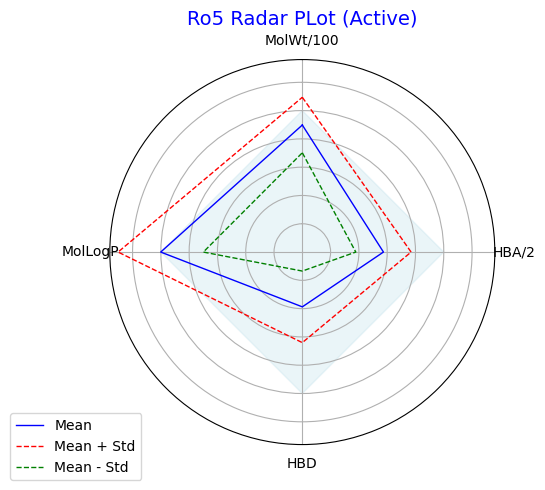

In [16]:
rule_of_5_features = ['CalcNumLipinskiHBA', 'CalcNumLipinskiHBD', 'MolLogP' , 'CalcExactMolWt']

ro5_descriptor_dict_active={}
for p in rule_of_5_features:
    ro5_descriptor_dict_active[p] = mol_features[mol_features[target_column]==1.0][p].values

visualization.create_rule_of_5_radar_plot(descriptors_dict=ro5_descriptor_dict_active
                                            , title="Ro5 Radar PLot (Active)", fig_pathname=None
                                            , figsize=(5,5))
# create_radar_plot(dataframe=mol_features, descriptors=rule_of_5_features, standardize=False, fig_pathname=None)

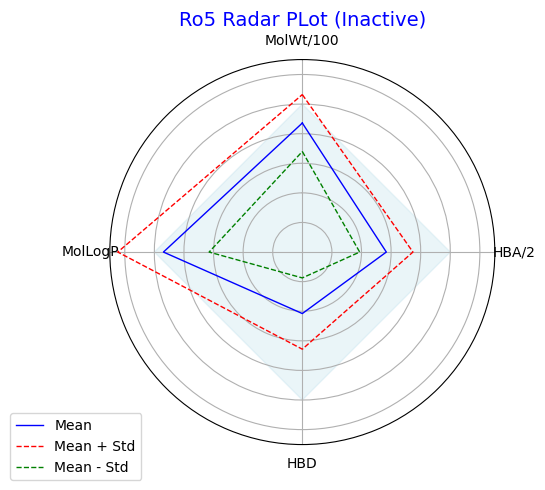

In [17]:
ro5_descriptor_dict_inactive={}
for p in rule_of_5_features:
    ro5_descriptor_dict_inactive[p] = mol_features[mol_features[target_column]==0.0][p].values

visualization.create_rule_of_5_radar_plot(descriptors_dict=ro5_descriptor_dict_inactive, title="Ro5 Radar PLot (Inactive)"
                                          , fig_pathname=None, figsize=(5,5)
                                          )

In [18]:
features_to_plot   = ['CalcNumLipinskiHBA', 'CalcNumLipinskiHBD', 'MolLogP' , 'CalcNumAromaticRings', 'CalcNumAliphaticRings', 'qed'
                      , 'CalcNumRotatableBonds', 'CalcNumAromaticRings', 'CalcNumAliphaticRings']
df_to_plot = mol_features[features_to_plot + [target_column]]
df_to_plot['MolWt/100'] = mol_features['CalcExactMolWt']/100
features_to_plot.append('MolWt/100')



/tmp/ipykernel_934181/4045493524.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_plot['MolWt/100'] = mol_features['CalcExactMolWt']/100


/home/djoy2409-wsl/projects/caismd_qsar_2024/lib/visualization.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot[label_column] = dataframe[label_column]


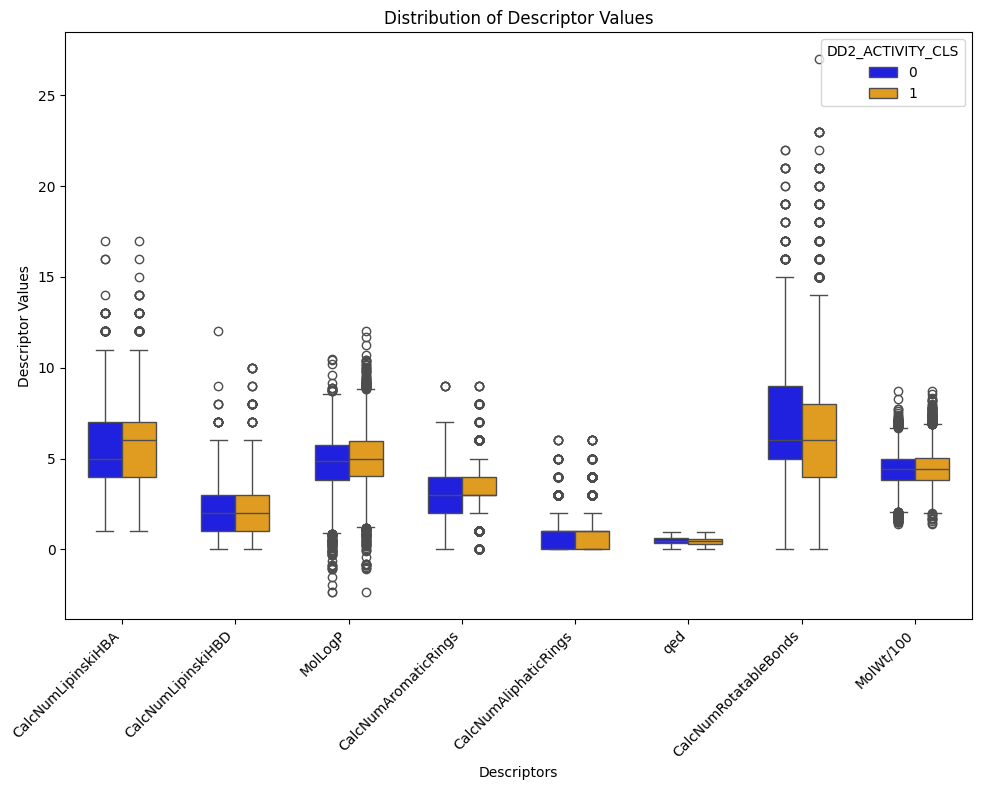

In [19]:
colors=['blue', 'orange']
visualization.plot_descriptor_distributions(dataframe=df_to_plot, descriptors=features_to_plot, label_column=target_column
                                            , colors=colors, standardize=False, figsize=(10,8), fig_pathname= f"{DATASET_DIR}/boxplot.jpg")

Box plots are useful as they provide a visual summary of the data enabling researchers to quickly identify mean values, the dispersion of the data set, and signs of skewness.
* The box or inter-quartile range represents the distribution of the middle 50% for the group
* The median (middle quartile) marks the mid-data point of the data
* The upper quartile is the top limit of the box. Seventy-five percent of the values are lower
* The lower quartile is the top limit of the box. Seventy-five percent of the values are higher

Certain observations are telling:
* Larger ranges indicate wider distribution, that is, more scattered data. E.g.: 'CalcNumrotatableBonds'
* If the boxes overlap, it suggests that there is no significant difference in the distribution of the data between the two classes. E.g.: 'CalcNumLipinskiHBD'
* If one box is entirely inside the other, it suggests a clear difference in the distributions. E.g.: 'CalcNumAromaticRings', which as seen above, is one of the most important features.
* The distribution of the number of Hydrogen bond acceptors ('CalcNumLipinskiHBA') is skewed psovitely towards the bottom for inactive molecules, and negatively towards the top for actives. Although the descriptors spans the same value range, active molecules tennd to have higher Hydrogen bond donors, compared to inactive moelcules.

### Functional Group Distributions
Functional groups an impact a molecule's ADME profile and function, since they are the reactive centers of organic molecules. For instance:
* the presence of a carboxyl group (-COOH) can make a compound acidic, and allow for proton donation. 
* the hydroxyl group (-OH) in alcohols can participate in hydrogen bonding
* Certain functional groups, such as polar groups (-OH, -NH2, -COOH), can increase the molecule's solubility in aqueous environments. This impacts a molecule availability.
* Certain functional groups can often be targets for metabolic enzymes. Examples include the methyl group, and the primary/secondary amine group.

In [20]:
# func_groups = [f for f in mol_features.columns if 'fr_' in f]
# print([f for f in mol_features.columns if 'fr_' in f])

### !!!! Be very careful about the definition of these SMARTS papperns. Some seem erroneous.
func_groups = ['fr_C_O', 'fr_Al_COO', 'fr_Al_OH', 'fr_Ar_COO', 'fr_Ar_N'
               , 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_Nhpyrrole', 'fr_SH', 'fr_aldehyde'
               , 'fr_alkyl_carbamate', 'fr_sulfonamd', 'fr_piperdine', 'fr_lactam', 'fr_lactone', 'fr_amide'
               # , 'fr_halogen', 'fr_nitro', 'fr_nitro_arom'
            ]
func_df = mol_features[func_groups + [target_column]]
func_df.head()

,fr_C_O,fr_Al_COO,fr_Al_OH,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_sulfonamd,fr_piperdine,fr_lactam,fr_lactone,fr_amide,DD2_ACTIVITY_CLS
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1
4,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1


In [21]:
## Counting the number of occurrences for each group
print(func_df[func_df[target_column]==0.0].shape, func_df[func_df[target_column]==1.0].shape)
grouped = func_df.groupby(target_column).sum()
grouped.iloc[:, -20:]



(5552, 19) (7935, 19)


,fr_C_O,fr_Al_COO,fr_Al_OH,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_sulfonamd,fr_piperdine,fr_lactam,fr_lactone,fr_amide
DD2_ACTIVITY_CLS,,,,,,,,,,,,,,,,,,
0,3531,145,2348,112,3453,1203,454,145,3531,1203,0,0,15,35,1418,4,209,3323
1,4540,149,3801,205,5487,1979,780,149,4540,1979,0,0,47,186,1656,4,379,4218


<Figure size 1000x1200 with 0 Axes>

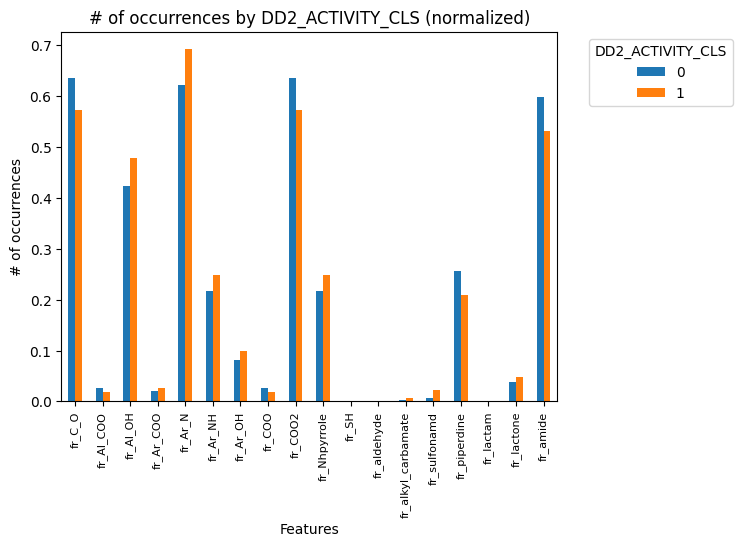

In [22]:
visualization.plot_histogram_by_target(func_df.iloc[:, :], target_column, normalize=True, stacked=False, figsize=(10, 12)
                                       , fig_pathname= f"{DATASET_DIR}/histogram_func_groups.jpg")


<h3>Bemis Murcko Scaffolds</h3>

The Bemis-Murcko scaffold, also known simply as the Murcko scaffold, is a method used in cheminformatics to identify the core structure or framework of a molecule. 
* This scaffold represents the essential, non-cyclic framework of a molecule by stripping away all substituents, side chains, and non-essential atoms.
* The goal is to simplify the molecular structure to its core framework, which can be useful in tasks such as compound clustering, similarity searching, and structure-activity relationship (SAR) analysis.

##### References
1. <a href="https://www.cureffi.org/2014/01/02/an-introduction-to-murcko-fragments-and-structure-activity-relationships-using-rcdk/">An introduction to Murcko fragments and structure-activity relationships using rcdk</a>

Number of Bemis-Murcko Scaffolds: 6954


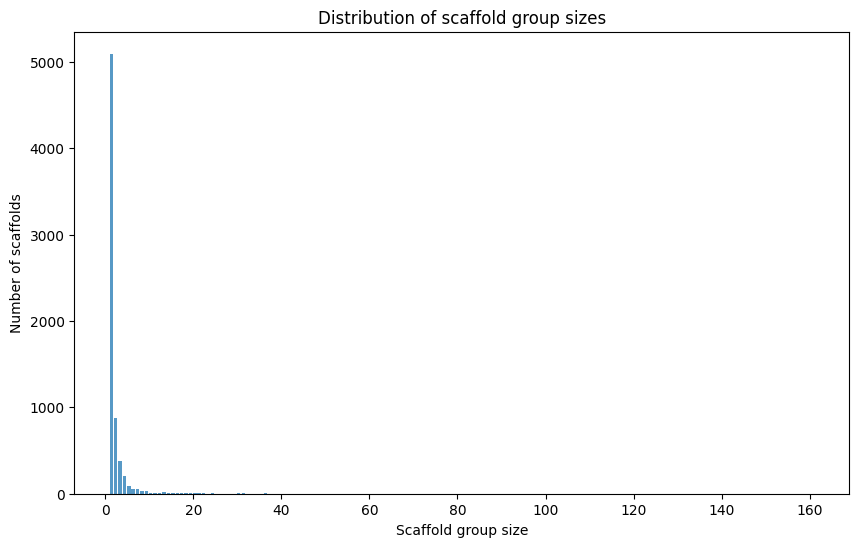

In [23]:
scaffold_splitter = splitters.ScaffoldSplitter()
scaffolds = scaffold_splitter.get_bemis_murcko_scaffolds(molecules = molecules_list[:], include_chirality=False)

print(f"Number of Bemis-Murcko Scaffolds: {len(scaffolds)}")
counts_by_scaffolds = [len(item[1]) for item in scaffolds.items()]
# print(counts_by_scaffolds)

visualization.plot_value_distribution(counts_by_scaffolds, xlabel="Scaffold group size", ylabel='Number of scaffolds'
                                      , title="Distribution of scaffold group sizes", bar_width=0.8
                                      , fig_pathname = f"{ROOT_DIR}/figs/distribution_of_scaffold_group_sizes.jpg")

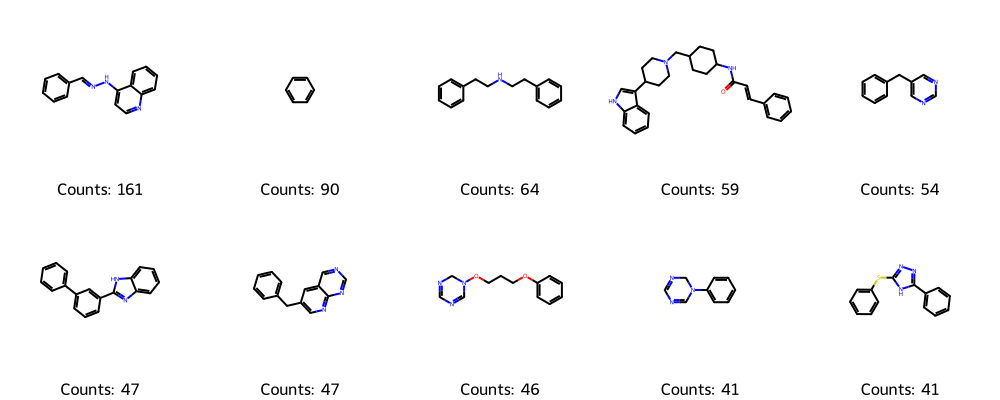

In [24]:
# Let's plot the 10 most occurring scaffolds, with their respective counts

top_10_scaffolds, counts =  [],[]

for item in list(scaffolds.items())[:10]:
    top_10_scaffolds.append(Chem.MolFromSmiles(item[0]))
    counts.append(f"Counts: {len(item[1])}")

Chem.Draw.MolsToGridImage(top_10_scaffolds, molsPerRow=5, subImgSize=(200, 200), legends=counts, highlightAtomLists=None, highlightBondLists=None, useSVG=False, returnPNG=False)

<h3>Clustering</h3>

In [25]:
cluster_splitter  = splitters.ClusterSplitter()

Largest cluster's size: 4954
Number of clusters: 501


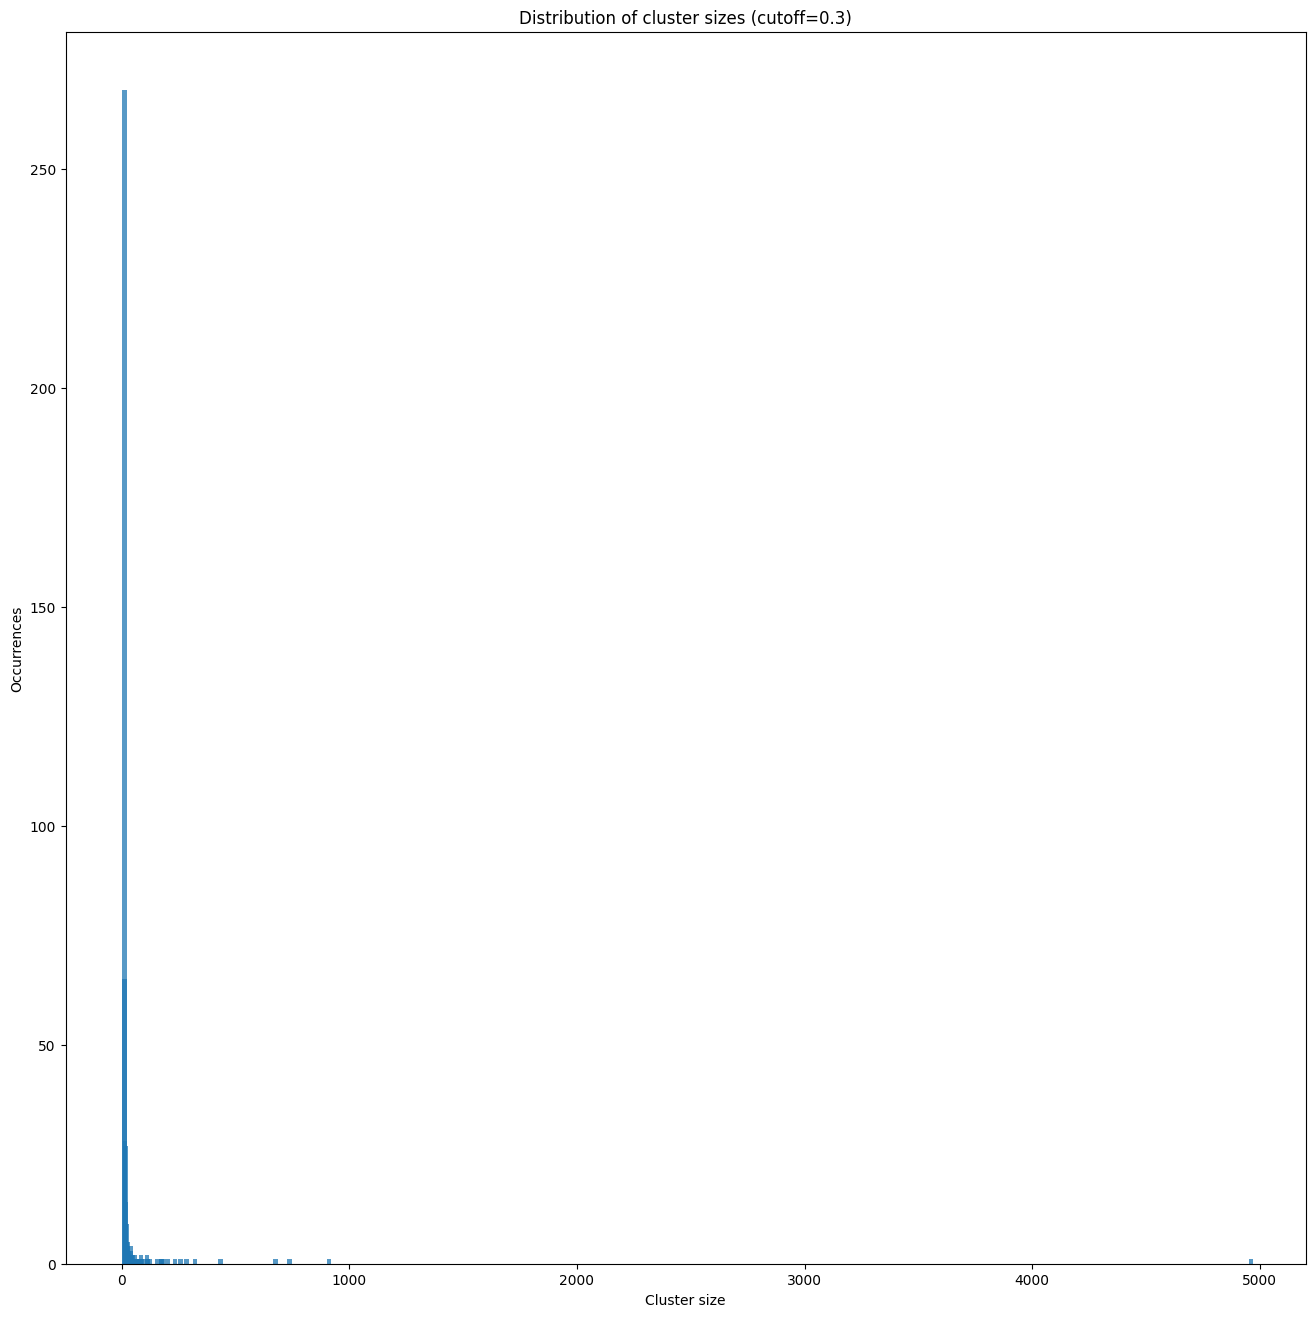

CPU times: user 6min 32s, sys: 10.4 s, total: 6min 43s
Wall time: 6min 44s


In [26]:
%%time
sim_cutoff=0.3
clusters_0 = cluster_splitter.cluster_molecules(molecules=molecules_list, count_bits=True, sim_cutoff=sim_cutoff)
utilities.save_to_pkl(clusters_0, f"{DATASET_DIR}/butina_taylor_cluster_morgan_simcutoff_03.pkl")
# print(f"{DATASET_DIR}/butina_taylor_cluster_morgan_simcutoff_03.pkl")
clusters_0 = utilities.get_from_pkl(f"{DATASET_DIR}/butina_taylor_cluster_morgan_simcutoff_03.pkl")
cluster_sizes_0 = [len(cluster) for cluster in clusters_0]
# print(cluster_sizes_0)
print(f"Largest cluster's size: {cluster_sizes_0[0]}")
print(f"Number of clusters: {len(clusters_0)}")
visualization.plot_value_distribution(cluster_sizes_0, xlabel="Cluster size", ylabel='Occurrences', figsize=(16,16)
                                        , bar_width=20, title=f"Distribution of cluster sizes (cutoff={sim_cutoff})"
                                        , fig_pathname = f"{ROOT_DIR}/figs/distribution_of_cluster_size_03.jpg")

Largest cluster's size: 1112
Number of clusters: 1634


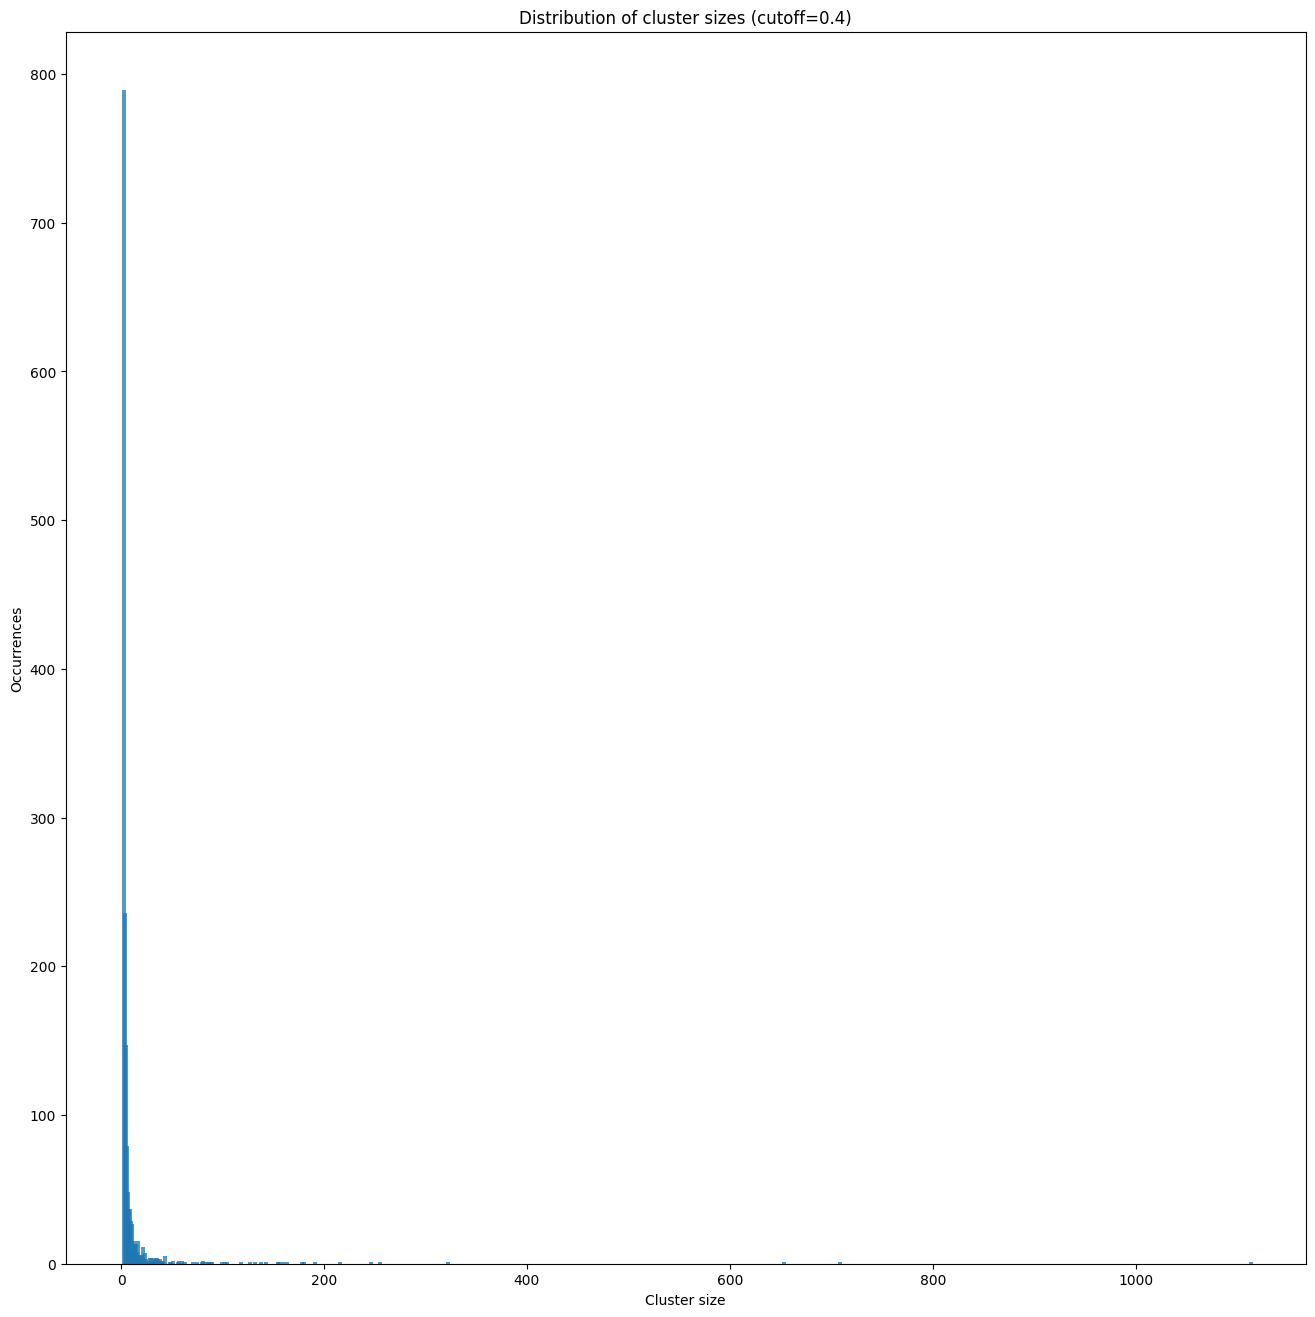

CPU times: user 2min 32s, sys: 4.09 s, total: 2min 36s
Wall time: 2min 36s


In [28]:
%%time
sim_cutoff=0.4
clusters_1 = cluster_splitter.cluster_molecules(molecules=molecules_list, count_bits=True, sim_cutoff=sim_cutoff)
utilities.save_to_pkl(clusters_1, f"{DATASET_DIR}/butina_taylor_cluster_morgan_simcutoff_04.pkl")

# clusters_1 = utilities.get_from_pkl(f"{DATASET_DIR}/butina_taylor_cluster_morgan_simcutoff_04.pkl")

cluster_sizes_1 = [len(cluster) for cluster in clusters_1]
# print(cluster_sizes_1)

print(f"Largest cluster's size: {cluster_sizes_1[0]}")
print(f"Number of clusters: {len(clusters_1)}")
visualization.plot_value_distribution(cluster_sizes_1, xlabel="Cluster size", ylabel='Occurrences', figsize=(16,16)
                                        , bar_width=4, title=f"Distribution of cluster sizes (cutoff={sim_cutoff})"
                                        , fig_pathname = f"{ROOT_DIR}/figs/distribution_of_cluster_size_04.jpg")

Largest cluster's size: 416
Number of clusters: 2978


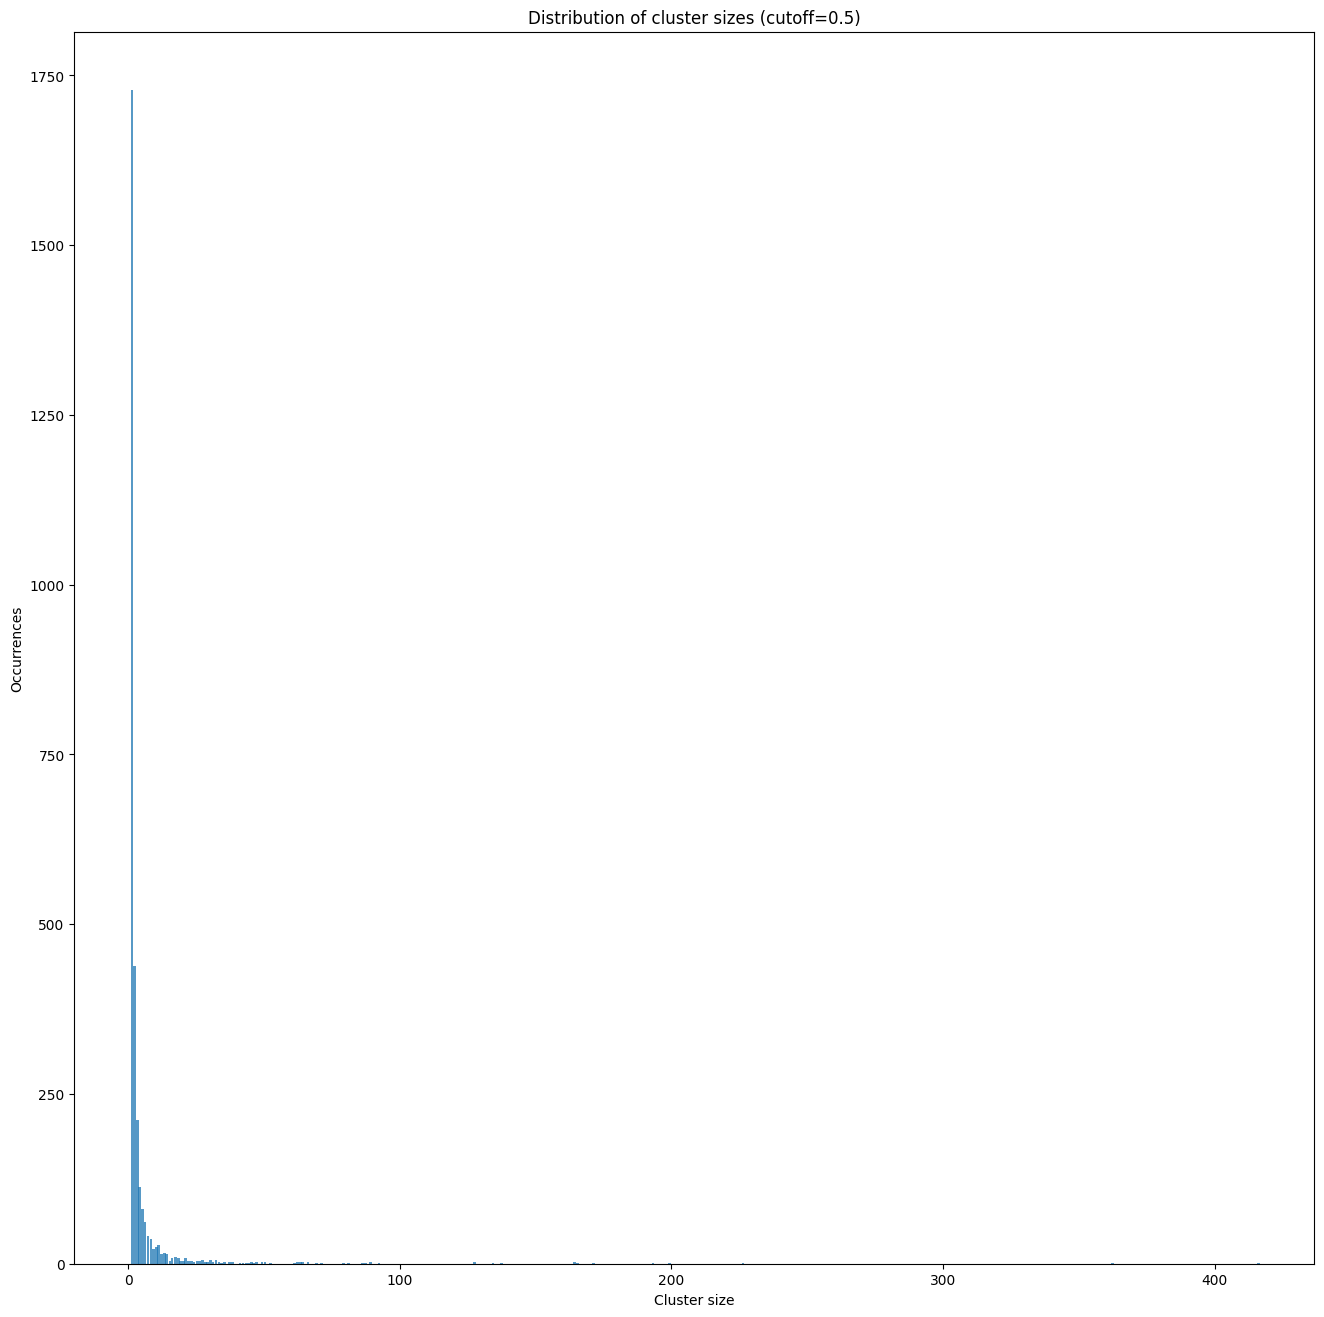

CPU times: user 2min 31s, sys: 2.63 s, total: 2min 34s
Wall time: 2min 34s


In [29]:
%%time
sim_cutoff = 0.5
clusters_2 = cluster_splitter.cluster_molecules(molecules=molecules_list, count_bits=True, sim_cutoff=sim_cutoff)
utilities.save_to_pkl(clusters_1, f"{DATASET_DIR}/butina_taylor_cluster_morgan_simcutoff_05.pkl")
# clusters_2 = utilities.get_from_pkl(f"{DATASET_DIR}/butina_taylor_cluster_morgan_simcutoff_05.pkl")
cluster_sizes_2 = [len(cluster) for cluster in clusters_2]
print(f"Largest cluster's size: {cluster_sizes_2[0]}")
print(f"Number of clusters: {len(clusters_2)}")
visualization.plot_value_distribution(cluster_sizes_2, xlabel="Cluster size", ylabel='Occurrences', figsize=(16,16)
                                        , bar_width=1, title=f"Distribution of cluster sizes (cutoff={sim_cutoff})"
                                        , fig_pathname = f"{ROOT_DIR}/figs/distribution_of_cluster_size_05.jpg")

Largest cluster's size: 84
Number of clusters: 6529


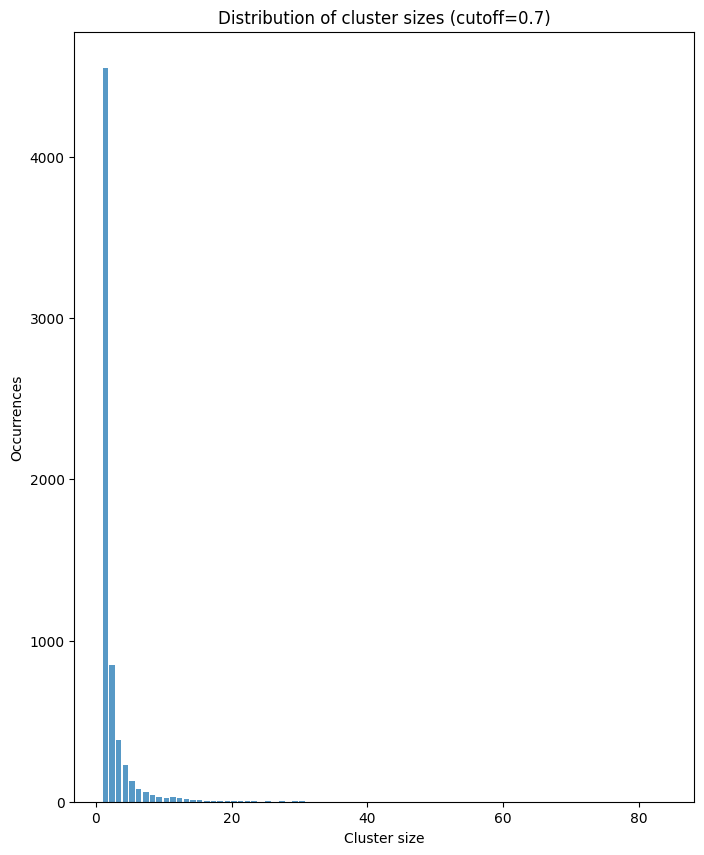

CPU times: user 3min 23s, sys: 1.64 s, total: 3min 24s
Wall time: 3min 24s


In [30]:
%%time
sim_cutoff=0.7
clusters_3 = cluster_splitter.cluster_molecules(molecules=molecules_list, count_bits=True, sim_cutoff=sim_cutoff)
utilities.save_to_pkl(clusters_3, f"{DATASET_DIR}/butina_taylor_cluster_morgan_simcutoff_07.pkl")
# clusters_3 = utilities.get_from_pkl(f"{DATASET_DIR}/butina_taylor_cluster_morgan_simcutoff_07.pkl")
cluster_sizes_3 = [len(cluster) for cluster in clusters_3]
print(f"Largest cluster's size: {cluster_sizes_3[0]}")
print(f"Number of clusters: {len(clusters_3)}")
visualization.plot_value_distribution(cluster_sizes_3, xlabel="Cluster size", ylabel='Occurrences'
                                        , figsize=(8,10), bar_width=0.8, title=f"Distribution of cluster sizes (cutoff={sim_cutoff})"
                                        , fig_pathname = f"{ROOT_DIR}/figs/distribution_of_cluster_size_07.jpg")

<p >Let's visualize some molecules from the largest clusters for similarity cut-offs aat 0.2 and 0.7.</p>

Ten molecules form the largest cluster (similarity cut-off: 0.3).


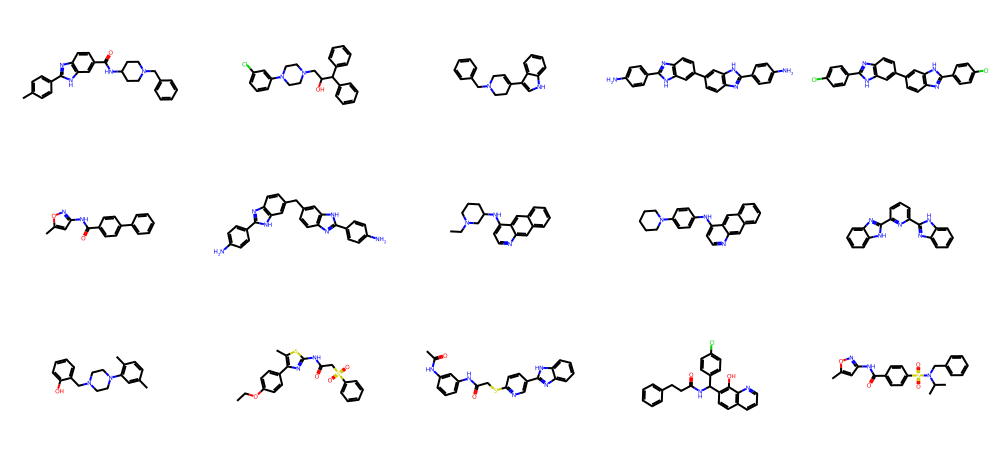

In [31]:
print("Ten molecules form the largest cluster (similarity cut-off: 0.3).")
Draw.MolsToGridImage(clusters_0[0][:15] , legends=None,molsPerRow=5, subImgSize=(200, 150), highlightAtomLists=None, highlightBondLists=None, useSVG=False, returnPNG=False)

Ten molecules form the largest cluster  (similarity cut-off: 0.7).


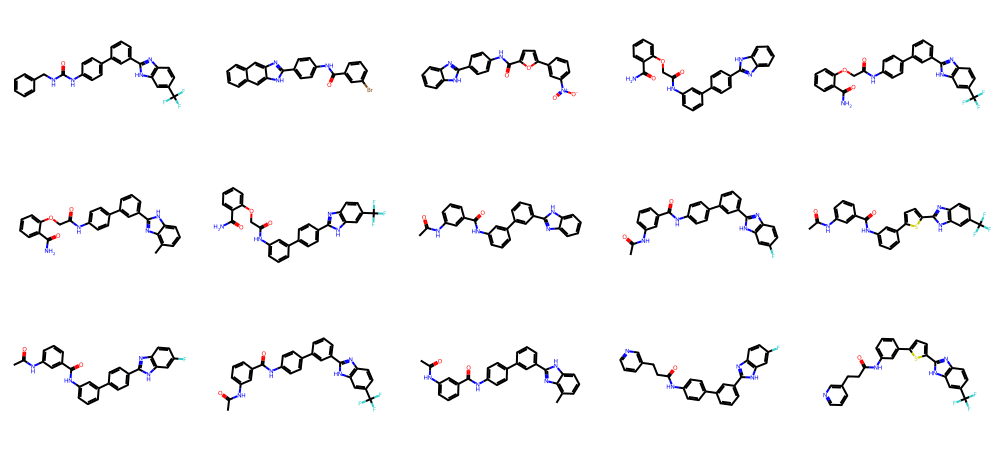

In [32]:
print("Ten molecules form the largest cluster  (similarity cut-off: 0.7).")
Draw.MolsToGridImage(clusters_2[0][:15] , legends=None,molsPerRow=5, subImgSize=(200, 150), highlightAtomLists=None, highlightBondLists=None, useSVG=False, returnPNG=False)

<div>

<p>As the different plots illustrate, <b>higer similarity cutoffs leads to more clusters, and a higher ratio of singleton clusters</b>. This is confirmed by the figures above. As the similarity cut-off increase, clusters are formed by increasingly more similar molecules.</p>
<p>Singletons often represent rare or outlier cases that may contain valuable information. Including these singletons in the training set ensures that the model learns to handle such cases effectively. Having saud that, selecting a cut-off that leads to fewer singletons might be a preferrable scenario.</p>
<ul>
<li>Fewer singletons might imply that the algorithm is finding more cohesive clusters, potentially capturing more meaningful patterns in the data. This could lead to better generalizability of the resulting model.</li>
<li>A small number of singleton clusters can be useful for identifying and isolating potential outliers or anomalies in your data.</li>
</ul>
<br/>
<p>We will select the similarity cut-off of 0.4, which yields 363 clusters. The largest cluster contains 44 molecules.</p>
</div>

<div>
<h3> UMAP Projections</h3>

<b>UMAP (Uniform Manifold Approximation and Projection)</b> is a nonlinear dimensionality reduction technique that is commonly used for visualizing high-dimensional data in lower dimensions. It is particularly well-suited for visualizing molecular structures that have been represented as high-dimensional vectors. UMAP has gained popularity due to <b>its ability to preserve both local and global structure of the data</b>, making it effective for visualizing complex relationships and clusters in high-dimensional data. This allows researchers to visualize patterns and clusters that might be difficult to discern in the original high-dimensional space.
<p> For the molecular representation of molecules, we will use the Morgen (ECFP), and MACCS fingerprint methods.</p>

</div>

In [33]:
fingerprint_type = 'morgan'
mol_fingerprints = pd.DataFrame(utilities.get_representations(dataset=dd2_data_df['largest_frag'].values, feature_list=None, fingerprint_type = fingerprint_type))
mol_fingerprints.index = dd2_data_df.index
mol_fingerprints.columns = [f'fp_{i+1}' for i in range(mol_fingerprints.shape[1])]
mol_fingerprints[target_column] = dd2_data_df[target_column]

mol_fingerprints.to_csv(f"{DATASET_DIR}/dd2-fingerprints-{fingerprint_type}.csv", index=False)
mol_fingerprints.head(2)

,fp_1,fp_2,fp_3,fp_4,fp_5,fp_6,fp_7,fp_8,fp_9,fp_10,...,fp_1016,fp_1017,fp_1018,fp_1019,fp_1020,fp_1021,fp_1022,fp_1023,fp_1024,DD2_ACTIVITY_CLS
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


/home/djoy2409-wsl/anaconda3/envs/caismd_qsar_2024/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


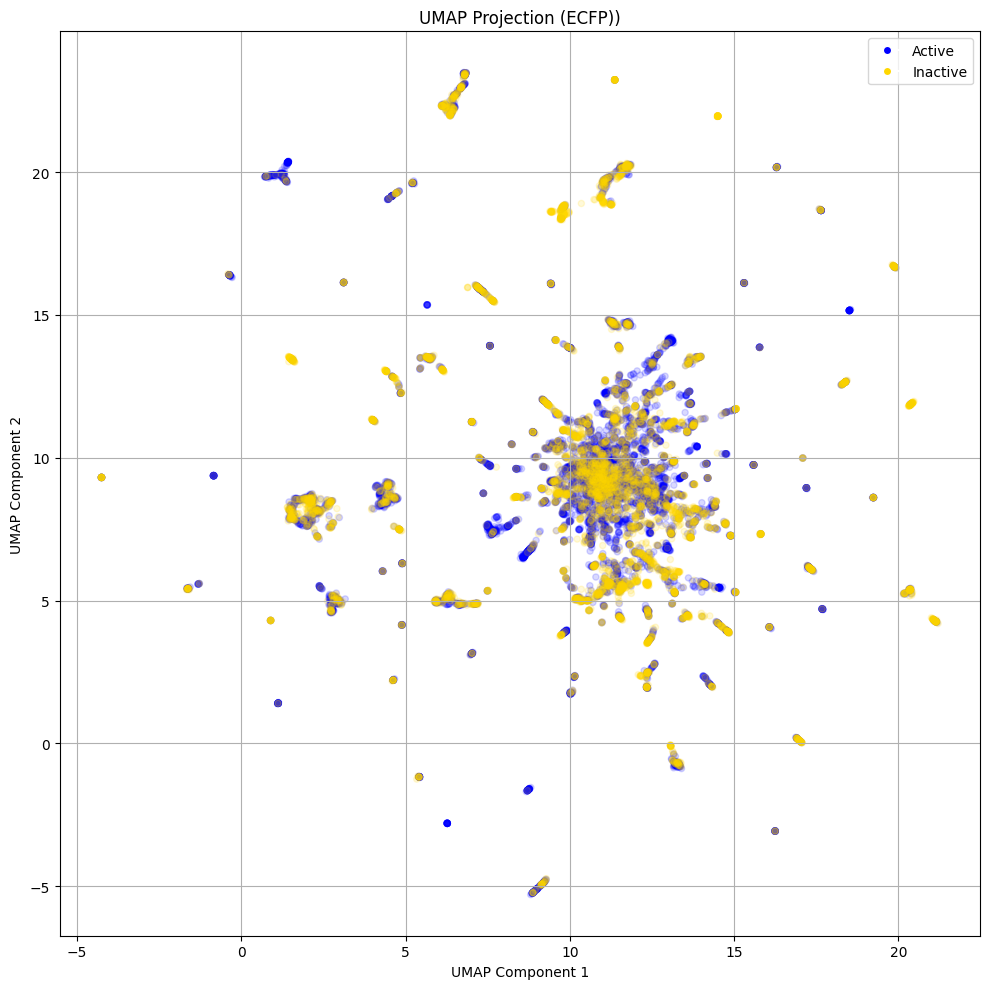

In [34]:
fp_features = mol_fingerprints.columns.difference([target_column]).tolist()
visualization.plot_umap(molecule_datasets=[mol_fingerprints[mol_fingerprints[target_column]==1.0][fp_features]
                            , mol_fingerprints[mol_fingerprints[target_column]==0.0][fp_features]]
                            , feature_list=fp_features
                            , min_dist=0.05, n_neighbors=20, metric='euclidean'
                            , colors={'Active':'blue', 'Inactive':'gold'}
                            , alpha=0.15, random_state=seed, plot_title = "UMAP Projection (ECFP))"
                            , figsize=(10,10)
                            ,fig_name=f"{ROOT_DIR}/figs/umap_projection_ecfp"
                        )


In [35]:
fingerprint_type  = 'maccs'
mol_fingerprints_maccs  = pd.DataFrame(utilities.get_representations(dataset=molecules_list.values, feature_list=None, fingerprint_type = fingerprint_type))
# mol_fingerprints_maccs  = pd.read_csv(f"{DATASET_DIR}/dd2-fingerprints-{fingerprint_type}.csv")
mol_fingerprints_maccs.index = dd2_data_df.index
fp_features_maccs = [f'fp_{i+1}' for i in range(mol_fingerprints_maccs.shape[1])]
mol_fingerprints_maccs.columns = fp_features_maccs
mol_fingerprints_maccs[target_column] = dd2_data_df[target_column]

# mol_fingerprints_maccs.to_csv(f"{DATASET_DIR}/dd2-fingerprints-{fingerprint_type}.csv", index=False)
mol_fingerprints_maccs.head(2)


,fp_1,fp_2,fp_3,fp_4,fp_5,fp_6,fp_7,fp_8,fp_9,fp_10,...,fp_159,fp_160,fp_161,fp_162,fp_163,fp_164,fp_165,fp_166,fp_167,DD2_ACTIVITY_CLS
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,1,1,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,1,0,1,0,1


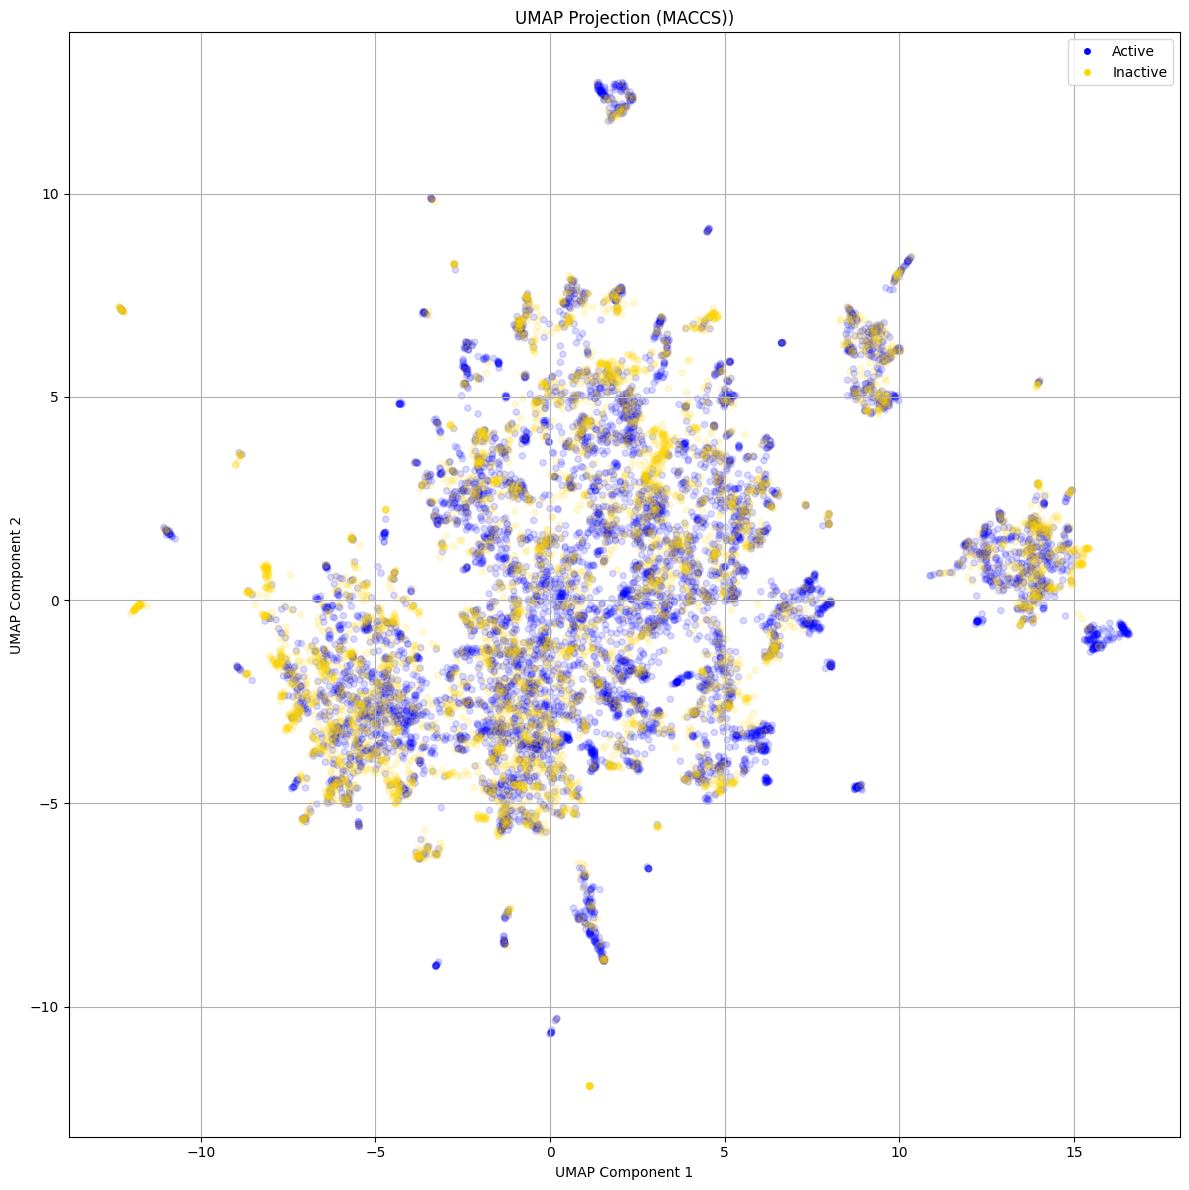

In [36]:
fp_features = mol_fingerprints_maccs.columns.difference([target_column]).tolist()
visualization.plot_umap(molecule_datasets=[mol_fingerprints_maccs[mol_fingerprints_maccs[target_column]==1.0][fp_features]
                            , mol_fingerprints_maccs[mol_fingerprints_maccs[target_column]==0.0][fp_features]]
                            , feature_list=fp_features
                            , min_dist=0.3, n_neighbors=20, metric='euclidean'
                            , colors={'Active':'blue', 'Inactive':'gold'}
                            , alpha=0.15, random_state=seed, plot_title = "UMAP Projection (MACCS))"
                            , figsize=(12,12)
                            ,fig_name=f"{ROOT_DIR}/figs/umap_projection_ecfp"
                        )

<h3 > (Dis)similarity Metrics</h3>
<div>
<p>Several distance metrics can be used to assess the average dissimilarity between molecules from our dataset. The include:</p>
<ul>
<li>The <b>Euclidean distance</b> tends to emphasize large differences in feature values and is sensitive to the scale of the features. In assessing the diversity of a molecular set, a higher average Euclidean distance between molecules suggests greater dissimilarity or diversity among them.</li>
<li>The <b>Manhattan distance</b> is less sensitive to outliers than Euclidean distance, making it potentially more robust in some scenarios.</li>
<li>The <b>Cosine distance</b> is often used when the magnitude of the vectors is less important than the direction, making it suitable for comparing the similarity of molecules based on their relative distribution of features. In assessing the diversity of a molecular set, a lower average cosine distance between molecules suggests greater similarity or overlap in their feature distributions. </li>
</ul>
</div>

In [37]:
%%time 

## To save time, and memory, let's visualize smaller set of compounds
vectors = mol_fingerprints[mol_fingerprints.columns.difference([target_column])].values[:500]
print("Average Euclidean Dissimilarity:           ", round(utilities.average_dissimilarity(vectors, metric='euclidean'), 3))
print("Average Normalized Euclidean Dissimilarity:", round(utilities.average_dissimilarity(vectors, metric='euclidean', normalize=True), 3))
print("Average Manhattan Dissimilarity:           ", round(utilities.average_dissimilarity(vectors, metric='manhattan'), 3))
print("Average Normalized Manhattan Dissimilarity:", round(utilities.average_dissimilarity(vectors, metric='manhattan', normalize=True), 3))
print("Average Cosine Dissimilarity:              ", round(utilities.average_dissimilarity(vectors, metric='cosine'), 3))

Average Euclidean Dissimilarity:            8.198
Average Normalized Euclidean Dissimilarity: 0.189
Average Manhattan Dissimilarity:            67.743
Average Normalized Manhattan Dissimilarity: 0.759
Average Cosine Dissimilarity:               0.756
CPU times: user 5.75 s, sys: 28.9 ms, total: 5.78 s
Wall time: 5.77 s


<h2> Data Splitting</h2>
This allows researchers to visualize patterns and clusters that might be difficult to discern in the original high-dimensional space. Tey allow to partition molecules into sets so as to build reliable models, and avoid overfitting. While there are many chemistry-agonistic techniques that allow to split data based on the sample labels, it is important to implement measures that can:
<ol>
    <li>minimize information leakage, for instance by placing highly similar molecules together</li>
    <li>maximize diversity within between sets, for instance, by also ensuring that small clusters (incl. singletons) are present in each set.</li>
</ol>
<p>For these reasons, we will perform a k-fold cross validation using clustering (based on morgan fingerprints). Ideally, we would like to address thhe aformentioned goals, while keeping the same ratio between active and inactive molecules within each fold/split.</p>

<p>We perform data splitting at this point to ensure that the models are trained, validated, and tested on the same data, to allow for reliable hyperparmaeter tuning, and performance comparison. The number of folds can be specified by the users. Five- and Ten-fold crosss validations are commonly used; however, readers are encouraged to try different values. </p>


<br><p><b style="color:orange">Why Cluster-based Splitting over Scaffold-based Splitting?</b> While scaffold splitting facilitates the identification of key structural motifs, and can enhance model interpretation, it has limitations in handling highly flexible or structurally diverse molecules,and may result in the loss of detailed iformation about specific functional groups or substituents, potentially oversimplifying structure-activity relationships. Moreover, In some cases, scaffold splitting may lead to overly strict splitting criteria, resulting in training, validation, and test sets that are too similar in chemical space.</p>

In [38]:
### Splitting data for k-fold cross validation
n_folds = 5
num_repeats = 1

kfold_splits = cluster_splitter.kfold_split(molecules_list, n_folds = n_folds, test_ratio=0.1, random_state=seed
                                            , num_repeats=num_repeats, sim_cutoff=0.4, return_as_indices=True
                                            , return_as_clusters=False
                                          )

## Save the splits to file. Splitting can sometimes be computationally expensive. so it is a good idea to save it.
kfold_splits_dict = {idx:value for idx, value in enumerate(kfold_splits)}
utilities.save_to_pkl(kfold_splits_dict, f"{DATASET_DIR}/kfold_{n_folds}_splits_{num_repeats}_repeats.json")



In [39]:
len(kfold_splits[0])

5

In [40]:
# kfold_splits_dict = utilities.get_from_pkl(f"{DATASET_DIR}/kfold_{n_folds}_splits_{num_repeats}_repeats.json")
# kfold_splits = kfold_splits_dict[0]
# mol_features = pd.read_csv(f"{DATASET_DIR}/dd2-mordred-rdkit.csv")


folds_features = utilities.get_features_for_folds(kfold_splits[0], mol_features[[target_column]])
mol_features_val_counts = mol_features[target_column].value_counts().to_dict()
print(f"\f Full Dataset:\n**************\nActives: {mol_features_val_counts[1]} - Inactives: {mol_features_val_counts[0]}\nActive/Inactive Ratio = {round(mol_features_val_counts[1]/mol_features_val_counts[0], 3)}")

print("\nActive/Inactive Ratios per CV fold:\n*****************************")
ratios = []
for i in range(len(folds_features)):
    # print(f"{i} :\n\tTrain {folds_features_desc_maccs[i][0][target_column].value_counts().to_dict()}\n\tVal: {folds_features_desc_maccs[i][1][target_column].value_counts().to_dict()} \n\t Test: {folds_features_desc_maccs[i][2][target_column].value_counts().to_dict()}")
    train = folds_features[i][0][target_column].value_counts().to_dict()
    val   = folds_features[i][1][target_column].value_counts().to_dict()
    test  = folds_features[i][2][target_column].value_counts().to_dict()
    # print(train)
    ratios.append([i+1, round(train[1]/train[0], 3), round(val[1]/val[0], 3), round(test[1]/test[0] ,3)])


ratios_df = pd.DataFrame(ratios, columns = ['Fold', 'Train_Ratio', 'Val_Ratio', 'Test_Ratio'])



ratios_df
# print(f"\n\tActive/Inactive Ratio (Fold {i+1}) :\n\t\tTrain {round(train[1]/train[0], 3)}\n\t\tVal:  {round(val[1]/val[0], 3)} \n\t\tTest: {round(test[1]/test[0] ,3)}\n")

[9712, 2427, 1348]
[9712, 2427, 1348]
[9712, 2427, 1348]
[9712, 2427, 1348]
[9708, 2431, 1348]
 Full Dataset:
**************
Actives: 7935 - Inactives: 5552
Active/Inactive Ratio = 1.429

Active/Inactive Ratios per CV fold:
*****************************


,Fold,Train_Ratio,Val_Ratio,Test_Ratio
0,1,1.333,1.822,1.548
1,2,1.437,1.340,1.548
2,3,1.466,1.239,1.548
3,4,1.394,1.512,1.548
4,5,1.460,1.259,1.548


<div>
<p>For the whole dataset, there are 1.43 times more active than inactive molecules. It is desirable that upon splitting using cluster, the ratio remains the same or at least very close within each fold. We can see here that for each each fold, the ratio is mstly conserved in the training, validation and test sets, with the only exceptions being the validaton set in Folds 1 and 5 (Assuming you used the same data, and clustering parameters).</p>
<p> !!! It is important to note that the test set is the same for each fold, as it was left out of the cluster-based splitting operation.</p>

<h5>Optional</h5>
The read is encouraged to try the methods described below.
<ol>
<li> There are several other types of splitting methods that take the chemistry into consideration. For instance, one could for instance use <a href=https://www.rdkit.org/docs/GettingStartedInPython.html>RDKit's MaxMin Splitter</a> to create train/validate/test sets. An example of such a method is implemented in the splitters module. Feel free to use it.</li>
<li>Scikit-learn also provides several chemistry-agnostic methods for data splitting, as described <a href=https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation>here</a>, which could be used training your data.</li>
</ol>
</div>